In [1]:
# Import packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import linregress
import time
import torchvision.utils

import importlib
import data
import helpers
import unet
import cloud_diffusion as cd

from helpers import fft
from helpers import ifft

from IPython.display import clear_output

In [2]:
# Uncomment and run these when making changes to .py files that require reloading modules
# Can also restart kernel, but this allows for reloading without running everything again
importlib.reload(data)
importlib.reload(helpers)
importlib.reload(unet)
importlib.reload(cd)

from helpers import fft
from helpers import ifft

In [3]:
def get_datasets(batch_size=64, grayscale=False):
    
    # Applies minimal transformations to STL10 data
    # Preserves 96x96 size but converts to grayscale
    transforms_list = [transforms.RandomCrop(160),
                       transforms.Resize(80),
                       transforms.ToTensor()]
                      
    if grayscale:
        transforms_list.append(transforms.Grayscale())
        
    minimal_transforms = transforms.Compose(transforms_list)

    dataset = datasets.CelebA(root='data', download=True, transform=minimal_transforms, split="train")
    
    return dataset

In [4]:
_dataset = get_datasets()
divisible_subset = np.arange(0, len(_dataset)//64*64)
dataset = torch.utils.data.Subset(_dataset, divisible_subset)

Files already downloaded and verified


In [5]:
dataset[0][0].shape

torch.Size([3, 80, 80])

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

torch.Size([3, 80, 80])


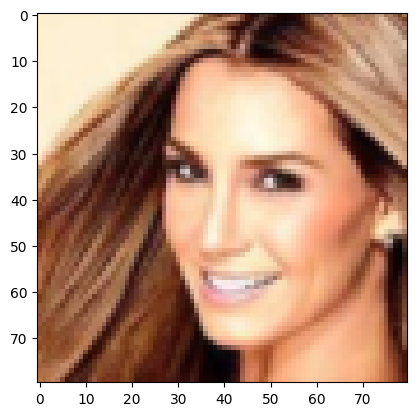

torch.Size([3, 80, 80])


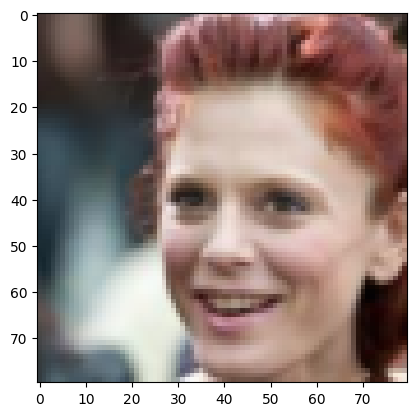

torch.Size([3, 80, 80])


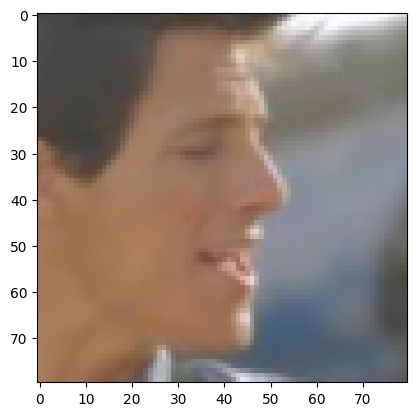

torch.Size([3, 80, 80])


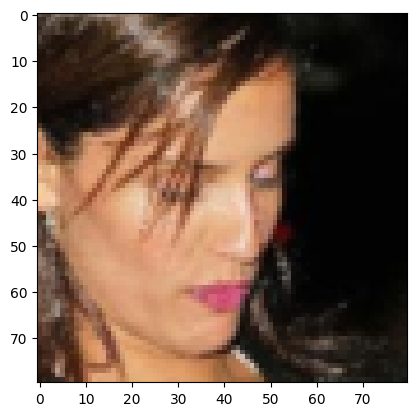

torch.Size([3, 80, 80])


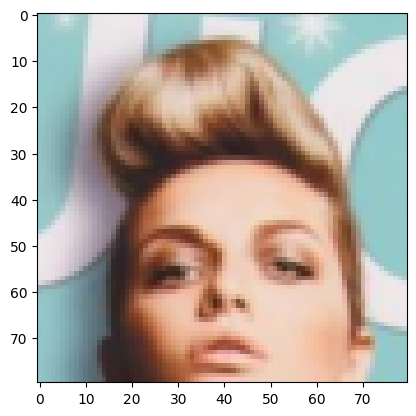

In [7]:
for i in range(5):
    print(dataset[i][0].squeeze().shape)
    plt.imshow(cd.movedim(dataset[i][0].squeeze()))
    plt.show()

In [8]:
mu, std = helpers.get_mu_and_std(dataset)

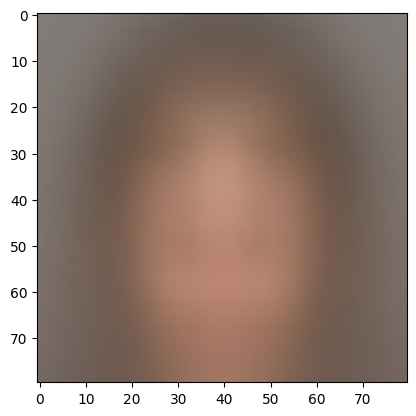

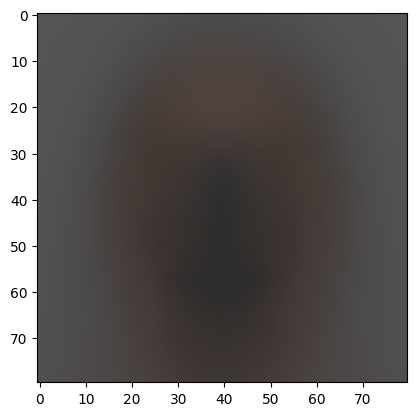

In [9]:
plt.imshow(cd.movedim(mu.to("cpu")))
plt.show()

plt.imshow(cd.movedim(std.to("cpu")))
plt.show()

In [10]:
mu = mu.mean(dim=(-2,-1), keepdim=True)
std = std.mean(dim=(-2,-1), keepdim=True)

In [11]:
sigma_color = helpers.get_sigma_color(dataset, mu, std, device="mps")

In [12]:
(L,V) = torch.linalg.eig(sigma_color.to("cpu"))

In [13]:
L = L.to("mps")
V = V.to("mps")
eigs = (L,V)

In [22]:
noise_generator_80 = helpers.NoiseGenerator(N=80, device="mps")

In [23]:
A = noise_generator_80.get_normalizing_A(Delta=1.0)

For N = 80, ∆ = 1.0 to normalize position-space cloud noise to have std=1 use:
A = 0.5258897616095324


In [24]:
z,Z = noise_generator_80.generate_color_noise(Delta=1.0, A=A, eigs=eigs, device="mps")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


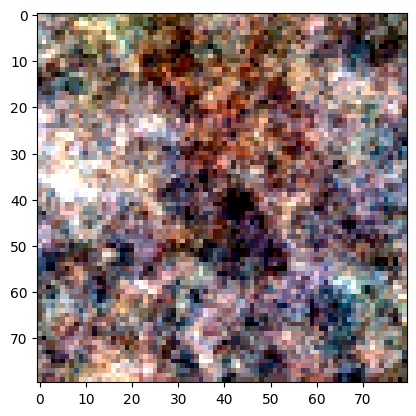

In [25]:
plt.imshow(cd.movedim(helpers.denormalize(z.real[np.random.randint(64)].to("cpu"), mu, std)))

In [26]:
mv = cd.ModelVariables()

In [27]:
# DataLoader
mv.dataloader = dataloader

# image norm, std, A, Delta
mv.mu=mu
mv.std=std
mv.A=A
mv.Delta=1.0
mv.eigs=eigs

# batch size, color channels, image size (NxN)
mv.batch_size=64
mv.color_channels=3
mv.N=80

# Scale factor for channels in UNet
# Default is 32 with 2M parameters. Choose another power of 2 for bigger or smaller model.
mv.scale_factor=32

# Device (note: can only use cpu on mac)
mv.device=torch.device("mps")

# Number of epochs
mv.n_epochs=3

# Diffusion time steps
mv.T=1000

# data type
mv.dtype=torch.float

# normalization mode for fft (default should be "ortho" for symmetric normalization)
mv.fft_norm="ortho"

# Activation function (LogMag is designed for complex tensors)
mv.activation=torch.nn.LeakyReLU()
#mv.activation=torch.nn.Tanh()
#mv.activation = unet.SymmetricLog()
#mv.activation = torch.nn.SiLU()

# Loss Function
#mv.loss_function = cd.FlatAbsoluteLoss(Delta=mv.Delta, dist=noise_generator_80.dist, device=mv.device, epsilon=0.01)
#mv.loss_function = cd.MeanAbsoluteLoss()
mv.loss_function = cd.KL_Loss_Color(Delta=mv.Delta, dist=noise_generator_80.dist, eigs=mv.eigs, device=mv.device, epsilon=0.03)
#mv.loss_function = cd.MeanAbsoluteLoss(device=mv.device)

# Diffusion schedule (cosine diffusion schedule is standard)
mv.diffusion_schedule=cd.cosine_diffusion_schedule

# AdamW optimizer parameters
mv.max_learning_rate=.001
mv.min_learning_rate=.0001
mv.betas=(0.9, 0.999)
mv.weight_decay=0.01

# Cap number of training batches (set to None for no cap)
mv.n_train_batches = None

In [28]:
cloud_diffusion_model = cd.RealCloudDiffusionModel(mv=mv)

RealCloudDiffusionModel Parameters = 1952163


Epoch: 3/3 | Batch: 2540/2543 | Loss: 90.069580078125
Total Time (minutes): 238.86131671667098 | Time per batch: 2.316411018371582


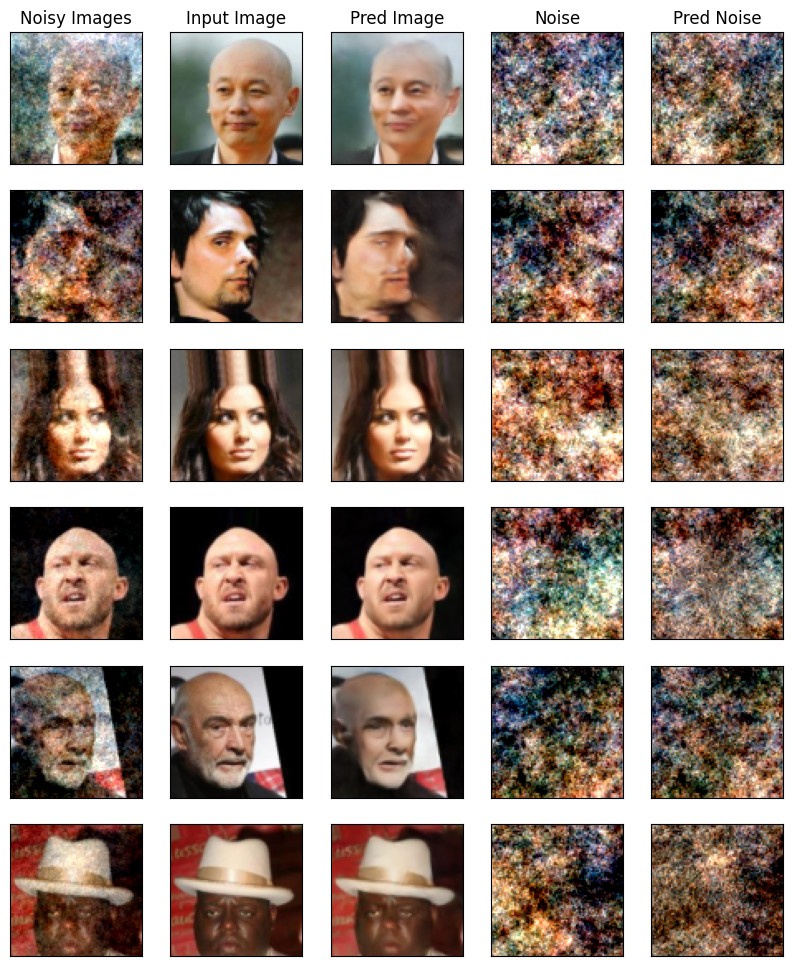

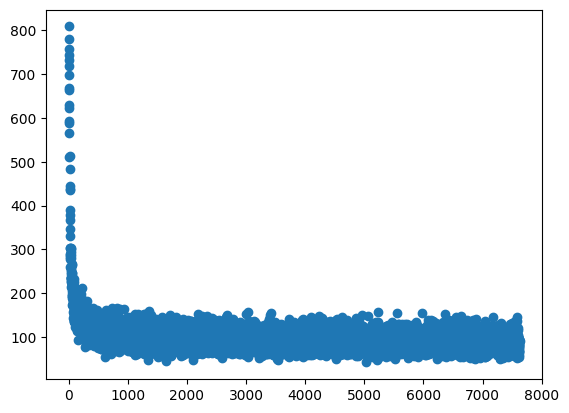

In [29]:
cloud_diffusion_model.mv = mv
losses = cloud_diffusion_model.train_it()

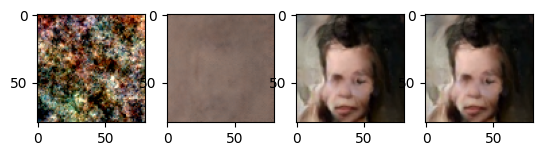

Step 1000/1000 | Time Elapsed Last 100 Steps = 16.925129175186157


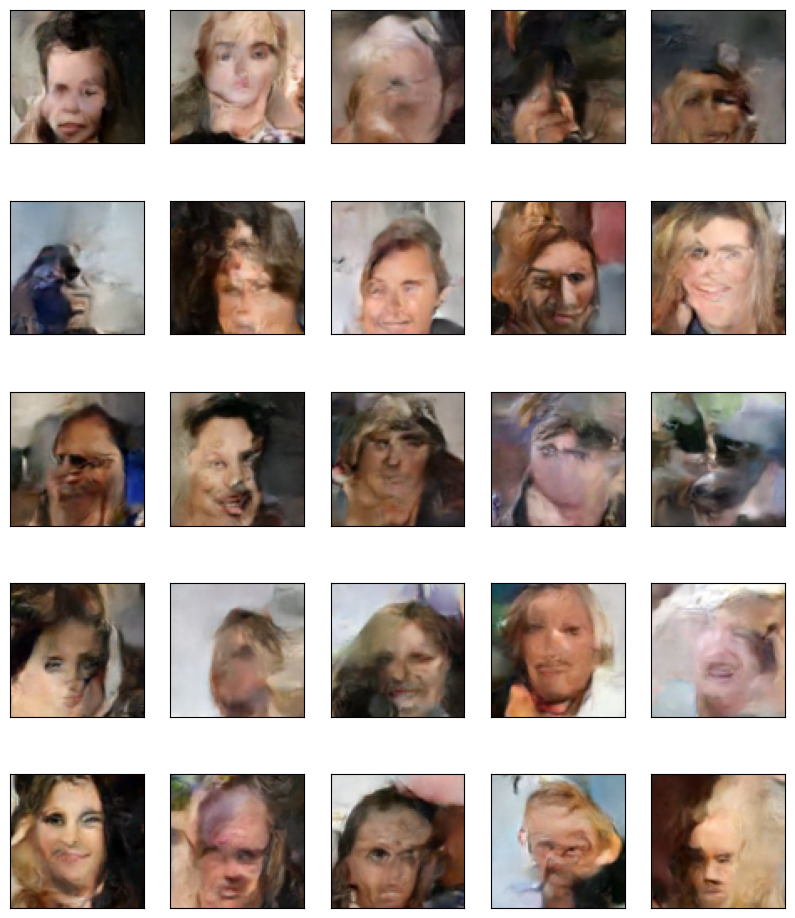

In [34]:
predicted_x0 = cd.real_reverse_diffusion(model=cloud_diffusion_model, 
                                         diffusion_steps=1000, 
                                         start_step=10,
                                         print_every=100,
                                         stochasticity=.2,
                                        )

In [ ]:
def save_checkpoint(model, filename, model_variables):
    
    filepath = f"checkpoints/{filename}.tar"
    
    torch.save({
                'model_variables': model_variables,
                'model_state_dict': model.network.state_dict(),
                'optimizer_state_dict': model.optimizer.state_dict(),
                'losses': losses
                }, filepath)
    print(f"Saved model to {filepath}")

In [ ]:
save_checkpoint(cloud_diffusion_model, "celeba_color_model_1", mv)

In [ ]:
image_grids = []
normed_predicted_x0 = cloud_diffusion_model.denormalize(predicted_x0)
for i in range(7):
    mini_batch = normed_predicted_x0[9*i:9*(i+1)]
    grid = torchvision.utils.make_grid(mini_batch, nrow=3, padding=20, pad_value=.5)                  
    image_grids.append(grid)
        
for grid in range(len(image_grids)):
    torchvision.utils.save_image(image_grids[grid], f"Images/celeba_white_1/images_{grid}.jpg")